<a href="https://colab.research.google.com/github/Szczureczek1983/Repozytorium2/blob/main/Kopia_notatnika_Embeddings_vs_One_Hot_plain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import requests
from nltk.corpus import stopwords
import nltk
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras import Input
from sklearn.preprocessing import LabelEncoder
import collections
import matplotlib.pyplot as plt

# paczki do modelowania
from keras import models
from keras import layers
from keras import regularizers



In [36]:
#Funkcje pomocnicze
def get_closest(x, embeddings, topn=3):
    """
    Get the closest embeddings calculating the euclidean distance
    Parameters
    ----------
    x: np.ndarray
      Vector containing an embedding
    top_k: int, optional
      Get the top k similar embeddings
    Returns
    -------
    dict
      Dict containing the top k similar embeddings to the given x
    """
    # Stack all embeddings in a single matrix. Note: the matrix dimention will be
    # V x D where V is the vocabulary size and D is the embedding dimension
    embedding_matrix = np.array(list(embeddings.values()))
    # Using broadcasting compute distance to each embedding in our vocabulary
    distances = x - embedding_matrix
    # Comoute the magnitude of each distance
    distances = np.linalg.norm(distances, axis=1)
    # Sort distance and keep the smallest k
    min_idx = np.argsort(distances)[:topn]
    return [list(embeddings)[i] for i in min_idx]

In [37]:
#ściagnięcie danych
nltk.download('stopwords')
url = "https://raw.githubusercontent.com/ashutoshmakone/Twitter-US-Airline-Sentiment-classification/main/Dataset/Tweets.csv"
df = pd.read_csv(url, sep=',')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
NB_WORDS = 10000  # Parametr odpowiadający za maksymalną liczbę słów w słowniku (najczęstsze)
NB_START_EPOCHS = 10  # Liczba epok podczas treningu
BATCH_SIZE = 512  # Wielkość mini-batcha
MAX_LEN = 24  # Maksymalna długość sekwencji 
GLOVE_DIM = 300  # Wymiarowość embeddinga GloVe

In [39]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=2)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=2)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [40]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [41]:
#wybranie z danych tylko kolumny z tekstem i kolumny z sentymentem
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [42]:
#PROSZĘ UZUPEŁNIĆ: Podział na próbkę treningową i testową
#wielkość probki testowej - 10%, ziarno dla losowania - 37
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size = 0.1, random_state = 37 )
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
#ograniczenie liczby próbek ze względu na Colaba (jak puszczane lokalnie to nie trzba używać)
IDX = 1200
X_train = X_train[:IDX]
y_train = y_train[:IDX]
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
print('++++++++++++++++++++++++++++++++++')
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])

# Train data samples: 13176
# Test data samples: 1464
++++++++++++++++++++++++++++++++++
# Train data samples: 1200
# Test data samples: 1464


In [43]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
# PROSZĘ UZUPEŁNIĆ:wyuczenie powyższego tokenizera na tekście treningowym
tk.fit_on_texts(X_train)

#PROSZĘ UZUPEŁNIĆ:Inferencja wyuczonego tokenizera na tekście treningowym i testowym
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [44]:
X_train_seq

[[210, 211, 896, 897, 456, 676, 1384, 85, 144, 337, 338, 145, 382],
 [8, 898, 899, 900, 901, 339, 899, 191, 552, 1385],
 [212, 1386, 239, 1387, 902, 1388, 192, 903, 192, 1389],
 [2, 1390, 553, 1391, 904, 51, 86, 383, 74, 269, 554, 905, 5, 87],
 [95, 304, 12, 1392, 1393],
 [24, 6],
 [57, 79, 28, 2, 457, 555, 2, 457, 58, 1394, 556],
 [128, 1395, 677, 18, 79, 28, 3, 18, 906, 213, 1396, 1397, 1398],
 [35, 270, 1399, 907, 384, 1400, 1401, 385, 908, 1402, 40, 271],
 [35, 120, 13, 42, 340, 678, 121, 88, 129, 172, 130, 156],
 [305, 272, 86, 75, 557, 3, 146, 173],
 [193, 679, 71],
 [131, 386, 458, 1, 214, 1403, 40, 1, 215, 1, 558, 36, 64, 341, 13],
 [44, 132, 216, 909, 910, 85, 157, 128, 306, 1404, 44, 273],
 [680,
  459,
  1405,
  1406,
  460,
  1407,
  54,
  113,
  1408,
  1409,
  240,
  147,
  1410,
  45,
  1411,
  69,
  13,
  307,
  911],
 [1412, 461, 912, 12, 11, 308, 174, 216, 913, 305, 148, 914, 149, 8, 915],
 [1413, 272, 130, 158, 338, 916, 3, 159, 1414, 1415, 387, 39, 917, 40, 1],
 [21

In [45]:
tk.word_index['airline']

68

In [46]:
helper_dict = {v:k for k,v in tk.word_index.items()}
[helper_dict[idx] for idx in X_train_seq[42]]

['flt',
 '470',
 'tampa',
 'clt',
 'late',
 'flight',
 'gonna',
 'miss',
 'conn',
 'bos',
 'do']

In [47]:
X_train.iloc[42]

' flt 470 Tampa CLT Late Flight gonna miss conn BOS do?'

In [48]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    1200.00000
mean       11.24000
std         4.16175
min         2.00000
25%         8.00000
50%        12.00000
75%        14.00000
max        24.00000
Name: text, dtype: float64

In [49]:
#PROSZĘ UZUPEŁNIĆ: Padding sekwencji do wartości MAX_LEN (treningowej i testowej)
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen = MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen = MAX_LEN)

In [50]:
X_test_seq_trunc[10]


array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   25,  628,
       2704, 1224], dtype=int32)

In [51]:
#Zastosowanie label encodera na sentymencie i stworzenie wektorów y
le = LabelEncoder()
#PROSZĘ UZUPEŁNIĆ: wytrenowanie na treningowym y Label Encodera oraz infernecja na teście
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)
#PROSZĘ UZUPEŁNIĆ: stworzenie y kategorycznych - treningowych i testowych
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [52]:
y_train_oh.shape

(1200, 3)

In [53]:
X_train.shape

(1200,)

## One Hot embeddings

In [54]:
from sklearn.preprocessing import OneHotEncoder
result_train = []
for seq in X_train_seq_trunc:
    result_train.append(to_categorical(seq, num_classes=NB_WORDS))
    
result_test = []
for seq in X_test_seq_trunc:
    result_test.append(to_categorical(seq, num_classes=NB_WORDS))

In [55]:
X_train_oh = np.array(result_train)
X_test_oh = np.array(result_test)
X_train_oh.shape

(1200, 24, 10000)

In [56]:
np.sum(X_train_oh[0,0])

1.0

In [57]:
oh_model = models.Sequential()
#PROSZĘ UZUPEŁNIĆ: dodanie następujących warst do modelu:
# - warstwa wejsciowa o odpowiednim kształcie!
# - warstwa spłaszczająca
# - warstwa gęsta z odpowiednią liczbą neuronów (sprawdź y) i funkcją softmax
oh_model.add(Input(shape = (MAX_LEN, NB_WORDS)))
oh_model.add(layers.Flatten())
oh_model.add(layers.Dense(3))
oh_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 240000)            0         
                                                                 
 dense_1 (Dense)             (None, 3)                 720003    
                                                                 
Total params: 720,003
Trainable params: 720,003
Non-trainable params: 0
_________________________________________________________________


In [58]:
oh_history = deep_model(oh_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh)


Epoch 1/10
3/3 - 4s - loss: 5.0175 - accuracy: 0.3208 - val_loss: 8.4892 - val_accuracy: 0.2322 - 4s/epoch - 1s/step
Epoch 2/10
3/3 - 2s - loss: 9.8854 - accuracy: 0.1942 - val_loss: 8.8416 - val_accuracy: 0.2309 - 2s/epoch - 623ms/step
Epoch 3/10
3/3 - 2s - loss: 10.5736 - accuracy: 0.1933 - val_loss: 9.3109 - val_accuracy: 0.1919 - 2s/epoch - 634ms/step
Epoch 4/10
3/3 - 2s - loss: 10.9744 - accuracy: 0.2025 - val_loss: 9.8459 - val_accuracy: 0.1592 - 2s/epoch - 637ms/step
Epoch 5/10
3/3 - 2s - loss: 10.7615 - accuracy: 0.1717 - val_loss: 9.7872 - val_accuracy: 0.1612 - 2s/epoch - 627ms/step
Epoch 6/10
3/3 - 2s - loss: 11.0041 - accuracy: 0.2200 - val_loss: 9.7525 - val_accuracy: 0.1626 - 2s/epoch - 669ms/step
Epoch 7/10
3/3 - 3s - loss: 11.0420 - accuracy: 0.2217 - val_loss: 9.7413 - val_accuracy: 0.1626 - 3s/epoch - 899ms/step
Epoch 8/10
3/3 - 2s - loss: 11.0550 - accuracy: 0.2225 - val_loss: 9.7410 - val_accuracy: 0.1626 - 2s/epoch - 623ms/step
Epoch 9/10
3/3 - 2s - loss: 11.0413 -

In [59]:
oh_history.history['accuracy'][-1]

0.2241666615009308

In [60]:
oh_results = test_model(oh_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, 3)
print('/n')
print('Test accuracy of one hot emmbeding model: {0:.2f}%'.format(oh_results[1]*100))

Epoch 1/3
3/3 - 1s - loss: 11.0410 - accuracy: 0.2250 - 1s/epoch - 461ms/step
Epoch 2/3
3/3 - 1s - loss: 11.0543 - accuracy: 0.2258 - 1s/epoch - 423ms/step
Epoch 3/3
3/3 - 1s - loss: 11.0543 - accuracy: 0.2258 - 1s/epoch - 394ms/step
46/46 [==============================] - 1s 18ms/step - loss: 9.7179 - accuracy: 0.1626
/n
Test accuracy of one hot emmbeding model: 16.26%


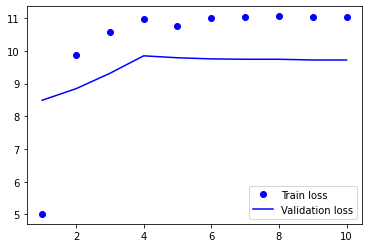

In [61]:
eval_metric(oh_history, 'loss')

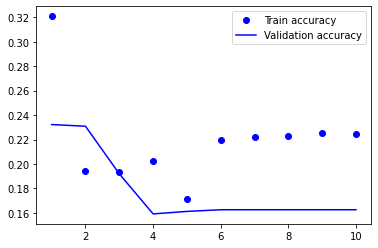

In [62]:
eval_metric(oh_history, 'accuracy')

## Glove embeddings

In [63]:
# #Glove 6B

!curl -OL http://nlp.stanford.edu/data/glove.6B.zip -o glove.6B.zip
# #wget
# # !wget http://nlp.stanford.edu/data/glove.6B.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   308    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   346    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  822M  100  822M    0     0  5239k      0  0:02:40  0:02:40 --:--:-- 5209k


In [64]:
# !unzip -o glove.6B.zip
!unzip -o /content/glove.6B.zip

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [65]:
glove_embeddings = {}
with open('glove.6B.300d.txt') as f:
    glove_embeddings = {l.split()[0]: np.array(l.split()[1:]).astype('float32') for l in f}

In [66]:
airline_words = ['airplane', 'airline', 'flight', 'luggage', 'djfhaskdjfasdf']
for w in airline_words:
    if w in glove_embeddings.keys():
        print('Found the word {} in the dictionary'.format(w))

Found the word airplane in the dictionary
Found the word airline in the dictionary
Found the word flight in the dictionary
Found the word luggage in the dictionary


In [67]:
get_closest(glove_embeddings['airplane'], glove_embeddings, topn = 10)

['airplane',
 'airplanes',
 'plane',
 'aircraft',
 'jet',
 'planes',
 'flying',
 'flight',
 'piloting',
 'flew']

In [68]:
#stworzenie macierzy mapowania pomiędzy słowami a odpowiadającymi im wektorami
emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    # The word_index contains a token for all words of the training data so we need to limit that
    if i < NB_WORDS:
        vect = glove_embeddings.get(w)
        # Check if the word from the training data occurs in the GloVe word embeddings
        # Otherwise the vector is kept with only zeros
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [70]:
glove_model = models.Sequential()
#PROSZĘ UZUPEŁNIĆ: dodanie następujących warst do modelu:
# - warstwa embedding o odpowiednim kształcie! (wykorzystaj NB_WORDS, GLOVE_DIM i MAX_LEN)
# - warstwa spłaszczająca
# - warstwa gęsta z odpowiednią liczbą neuronów (sprawdź y) i funkcją softmax
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(3, activation = 'softmax'))
glove_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 24, 300)           3000000   
                                                                 
 flatten_3 (Flatten)         (None, 7200)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 21603     
                                                                 
Total params: 3,021,603
Trainable params: 3,021,603
Non-trainable params: 0
_________________________________________________________________


In [71]:
#UWAGA - musimy zablokować możliwość trenowania warstwy z embeddingami glove!
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False
glove_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 24, 300)           3000000   
                                                                 
 flatten_3 (Flatten)         (None, 7200)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 21603     
                                                                 
Total params: 3,021,603
Trainable params: 21,603
Non-trainable params: 3,000,000
_________________________________________________________________


In [72]:
glove_history = deep_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh)
glove_history.history['accuracy'][-1]

Epoch 1/10
3/3 - 1s - loss: 0.9197 - accuracy: 0.5400 - val_loss: 0.8534 - val_accuracy: 0.6223 - 1s/epoch - 354ms/step
Epoch 2/10
3/3 - 0s - loss: 0.7142 - accuracy: 0.7025 - val_loss: 0.8331 - val_accuracy: 0.6455 - 125ms/epoch - 42ms/step
Epoch 3/10
3/3 - 0s - loss: 0.6454 - accuracy: 0.7400 - val_loss: 0.8227 - val_accuracy: 0.6530 - 112ms/epoch - 37ms/step
Epoch 4/10
3/3 - 0s - loss: 0.5950 - accuracy: 0.7700 - val_loss: 0.8128 - val_accuracy: 0.6503 - 120ms/epoch - 40ms/step
Epoch 5/10
3/3 - 0s - loss: 0.5555 - accuracy: 0.7875 - val_loss: 0.8053 - val_accuracy: 0.6551 - 124ms/epoch - 41ms/step
Epoch 6/10
3/3 - 0s - loss: 0.5206 - accuracy: 0.7975 - val_loss: 0.7992 - val_accuracy: 0.6646 - 124ms/epoch - 41ms/step
Epoch 7/10
3/3 - 0s - loss: 0.4906 - accuracy: 0.8142 - val_loss: 0.7900 - val_accuracy: 0.6619 - 151ms/epoch - 50ms/step
Epoch 8/10
3/3 - 0s - loss: 0.4621 - accuracy: 0.8492 - val_loss: 0.7991 - val_accuracy: 0.6612 - 140ms/epoch - 47ms/step
Epoch 9/10
3/3 - 0s - loss

0.8658333420753479

In [73]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

Epoch 1/3
3/3 - 0s - loss: 0.3944 - accuracy: 0.8967 - 59ms/epoch - 20ms/step
Epoch 2/3
3/3 - 0s - loss: 0.3764 - accuracy: 0.8858 - 64ms/epoch - 21ms/step
Epoch 3/3
3/3 - 0s - loss: 0.3581 - accuracy: 0.9075 - 57ms/epoch - 19ms/step
46/46 [==============================] - 0s 2ms/step - loss: 0.7953 - accuracy: 0.6701
/n
Test accuracy of word glove model: 67.01%


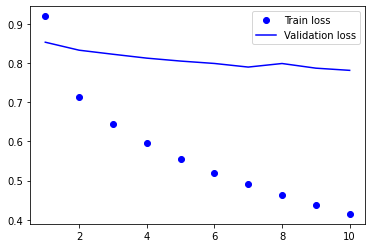

In [74]:
eval_metric(glove_history, 'loss')

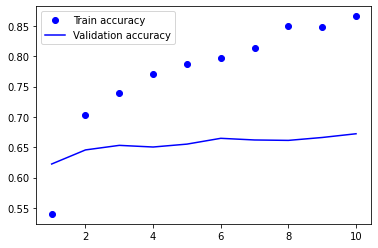

In [75]:
eval_metric(glove_history, 'accuracy')

## Extra section: Trainable Embeddings

In [ ]:
emb_model = models.Sequential()
#PROSZĘ UZUPEŁNIĆ: dodanie następujących warst do modelu:
# - warstwa embedding o odpowiednim kształcie - użyj wymiarowości wektora 8 (wykorzystaj NB_WORDS i MAX_LEN)
# - warstwa spłaszczająca
# - warstwa gęsta z odpowiednią liczbą neuronów (sprawdź y) i funkcją softmax

emb_model.summary()

In [ ]:
emb_history = deep_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh)
emb_history.history['accuracy'][-1]

In [ ]:
emb_results = test_model(emb_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print('/n')
print('Test accuracy of word glove model: {0:.2f}%'.format(emb_results[1]*100))

In [ ]:
eval_metric(emb_history, 'loss')

In [ ]:
eval_metric(emb_history, 'accuracy')